<h1><center> Visualization <br><br>
    <center> Wendy Shi

## TOC

- [Preparation](#Preparation)
- [Home Location](#Home-location)

# Preparation

In [1]:
#skmob
import skmob
import geopandas as gpd
from skmob.models.epr import DensityEPR
from skmob.measures.individual import home_location
from skmob.measures.individual import jump_lengths

#standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import scipy.stats as stats

#visualization
import seaborn as sns

#Geopandas related
import fiona
from shapely.geometry import shape

## Subsetting

In [2]:
#Load data
node_dict = pd.read_csv("../../Data/nodes_considered.csv")

#Standardize GEOID
node_dict["GEO_ID"] = node_dict["GEO_ID"].apply(lambda x: f"{int(x):05d}") #turn GEOID into 6 digit format

#rename column
rename = {'GEO_ID' : 'GEOID'}
node_dict = node_dict.rename(columns = rename)

#State ID: Add a new column
node_dict['State'] = node_dict['GEOID'].str[:2]
node_dict.head(3)

,index,GEOID,State
0,0,01001,01
1,1,01003,01
2,2,01005,01


In [11]:
#print out the number of States that we want
IL = node_dict[node_dict['State'] == '17']
print(AZ.shape)
IL.head(3)

(86, 3)


,index,GEOID,State
450,450,17001,17
451,451,17005,17
452,452,17007,17


## US Shape File

In [12]:
shape_file = pd.read_csv("../../Data/us_shapefile_county.csv")
shape_file.head(3)

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,State_1,Alpha code,Region,Division,CDC region,FIPS code,2013 code,U/R,pop2020,pop2021
0,48301,48,301,Loving,County,668.925,Texas,TX,South,West South Central,6.0,48301,6,R,67.0,57.0
1,48269,48,269,King,County,910.872,Texas,TX,South,West South Central,6.0,48269,6,R,270.0,258.0
2,48261,48,261,Kenedy,County,1458.329,Texas,TX,South,West South Central,6.0,48261,5,R,346.0,340.0


In [13]:
#Check how many state does NY has in total
AZ_sub = shape_file[shape_file['State_1'] == 'Illinois']
print(AZ_sub.shape)
AZ_sub.head(3)

(102, 16)


,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,State_1,Alpha code,Region,Division,CDC region,FIPS code,2013 code,U/R,pop2020,pop2021
217,17069,17,69,Hardin,County,177.528,Illinois,IL,Midwest,East North Central,5.0,17069,6,R,3634.0,3650.0
226,17151,17,151,Pope,County,368.770,Illinois,IL,Midwest,East North Central,5.0,17151,6,R,3744.0,3779.0
268,17013,17,13,Calhoun,County,253.825,Illinois,IL,Midwest,East North Central,5.0,17013,2,U,4411.0,4369.0


In [15]:
IL_name_id_pop = shape_file[(shape_file["STATE"] == 17) & (shape_file["pop2020"] > 11000)] 

rename = {"GEO_ID" : "GEOID"}
IL_name_id_pop = IL_name_id_pop.rename(columns = rename)
IL_name_id_pop = IL_name_id_pop[['GEOID', 'NAME','LSAD','STATE','State_1','pop2020']]
AZ_name_id_pop['GEOID'] = IL_name_id_pop['GEOID'].apply(lambda x: f"{int(x):05d}") 
print(IL_name_id_pop.shape)
IL_name_id_pop.head()

(86, 6)


,GEOID,NAME,LSAD,STATE,State_1,pop2020
795,17185,Wabash,County,17,Illinois,11316.0
822,17123,Marshall,County,17,Illinois,11691.0
832,17061,Greene,County,17,Illinois,11915.0
861,17129,Menard,County,17,Illinois,12265.0
903,17017,Cass,County,17,Illinois,12956.0


In [16]:
IL_name_id_pop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 795 to 3105
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GEOID    86 non-null     int64  
 1   NAME     86 non-null     object 
 2   LSAD     86 non-null     object 
 3   STATE    86 non-null     int64  
 4   State_1  86 non-null     object 
 5   pop2020  86 non-null     float64
dtypes: float64(1), int64(2), object(3)
memory usage: 4.7+ KB


In [17]:
IL_name_id_pop['GEOID'] = IL_name_id_pop['GEOID'].astype(str)
#This is the subsetting list!!!-----county list include county of pop less than 11,000---
county_list = IL_name_id_pop['GEOID'].tolist() 
print(len(county_list))

86


#

# Population Districts 
- Tracts, Block Groups and Blocks

## Census Block Group

In [21]:
data = []

with fiona.open("tl_2020_17_bg/tl_2020_17_bg.shp") as src:
    for feature in src:
        row = dict(feature['properties'])        # convert to dict
        row['geometry'] = shape(feature['geometry'])  # shapely geometry
        data.append(row)

il_bg_df = pd.DataFrame(data)

il_bg_sf = gpd.GeoDataFrame(il_bg_df, geometry='geometry')
il_bg_sf.head(3) 

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17,043,841316,1,170438413161,Block Group 1,G5030,S,3149456,85825,+41.9776901,-088.1968528,"POLYGON ((-88.20740 41.98733, -88.20728 41.987..."
1,17,043,841403,1,170438414031,Block Group 1,G5030,S,1286384,7410,+41.8646714,-088.1510559,"POLYGON ((-88.16152 41.87110, -88.16150 41.871..."
2,17,039,971400,1,170399714001,Block Group 1,G5030,S,119380410,2350925,+40.2200603,-088.6970357,"POLYGON ((-88.74649 40.22437, -88.74647 40.226..."


In [10]:
#url = "https://www2.census.gov/geo/tiger/TIGER2021/BG/tl_2021_35_bg.zip"
#ny_bg_sf = gpd.read_file(url)
#print(ny_bg_sf.columns)
#print(ny_bg_sf.shape)
#ny_bg_sf.head(1) 

## Test: Accquiring Census Block Group Population Data

### Instruction generated by ChatGTP:

- For New York census block group population data specifically, you can follow these steps:

- Go to https://data.census.gov/
- In the search bar, type "population"
- Under "Geography," select "Block Group"
- Then select "Washington" as the state
- Choose the counties and block groups you're interested in
- Select the appropriate ACS 5-Year Estimates table (the latest available would be best)

For population data specifically, look for table B01003 "Total Population" which gives you the basic population count.

If you want to get Decennial Census Data, Do the same thing and look for Decennial Census, look for P1 Data

In [22]:
bg_pop_raw = pd.read_csv("ACSDT5Y2020/ACSDT5Y2020.B01003-Data.csv")
bg_pop_raw = bg_pop_raw.drop(index=[0, 1]) #Drop the first row: first row is the total state population
print(bg_pop_raw.shape)
bg_pop_raw.head(3)

(9897, 5)


,GEO_ID,NAME,B01003_001E,B01003_001M,Unnamed: 4
2,1500000US170010001002,"Block Group 2, Census Tract 1, Adams County, I...",717,321,NaN
3,1500000US170010001003,"Block Group 3, Census Tract 1, Adams County, I...",648,203,NaN
4,1500000US170010001004,"Block Group 4, Census Tract 1, Adams County, I...",1002,332,NaN


In [28]:
#After inspect the dataframe, we can observe that there's also state level population included
#So we drop them
#bg_pop = bg_pop_raw.iloc[39:].copy()
#bg_pop.head(3)
bg_pop = bg_pop_raw

In [29]:
bg_pop = bg_pop[['GEO_ID', 'B01003_001E']].copy()
rename = {'B01003_001E' : 'Population'}
bg_pop  = bg_pop.rename(columns = rename)
bg_pop.head(3)

,GEO_ID,Population
2,1500000US170010001002,717
3,1500000US170010001003,648
4,1500000US170010001004,1002


In [30]:
bg_pop['Population'] = bg_pop['Population'].astype(int)
sum_value = bg_pop['Population'].sum()
print(sum_value)

12715022


In [31]:
bg_pop['GEOID'] = bg_pop['GEO_ID'].str[-12:]
bg_pop.head(3)

,GEO_ID,Population,GEOID
2,1500000US170010001002,717,170010001002
3,1500000US170010001003,648,170010001003
4,1500000US170010001004,1002,170010001004


In [32]:
bg_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9897 entries, 2 to 9898
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   GEO_ID      9897 non-null   object
 1   Population  9897 non-null   int64 
 2   GEOID       9897 non-null   object
dtypes: int64(1), object(2)
memory usage: 232.1+ KB


In [33]:
bg_pop = bg_pop[['GEOID', 'Population']].copy()
bg_pop['COUNTY'] = bg_pop['GEOID'].str[:5]
bg_pop_new = bg_pop[bg_pop['COUNTY'].isin(county_list)]
print(bg_pop_new.shape)
bg_pop_new.head()

(9776, 3)


,GEOID,Population,COUNTY
2,170010001002,717,17001
3,170010001003,648,17001
4,170010001004,1002,17001
5,170010001005,1098,17001
6,170010002011,1037,17001


In [34]:
print(len(bg_pop_new['COUNTY'].unique()))

86


## Merge Data

In [35]:
tessellation = pd.merge(il_bg_sf, bg_pop_new, on = 'GEOID', how = 'inner')
print(tessellation.shape)
tessellation.head(3)

(9776, 15)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Population,COUNTY
0,17,043,841316,1,170438413161,Block Group 1,G5030,S,3149456,85825,+41.9776901,-088.1968528,"POLYGON ((-88.20740 41.98733, -88.20728 41.987...",1508,17043
1,17,043,841403,1,170438414031,Block Group 1,G5030,S,1286384,7410,+41.8646714,-088.1510559,"POLYGON ((-88.16152 41.87110, -88.16150 41.871...",1497,17043
2,17,039,971400,1,170399714001,Block Group 1,G5030,S,119380410,2350925,+40.2200603,-088.6970357,"POLYGON ((-88.74649 40.22437, -88.74647 40.226...",1114,17039


In [36]:
len(tessellation['COUNTYFP'].unique())

86

In [37]:
#county_list = tessellation['COUNTYFP'].unique().tolist()#
#county_list

#

# Individual Trajectory Generation

In [39]:
tessellation = tessellation[['GEOID', 'Population', 'geometry']].copy()
tessellation = tessellation.loc[tessellation['Population'] != 0].copy()
print(tessellation.info())
tessellation.head(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 9762 entries, 0 to 9775
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       9762 non-null   object  
 1   Population  9762 non-null   int64   
 2   geometry    9762 non-null   geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 305.1+ KB
None


,GEOID,Population,geometry
0,170438413161,1508,"POLYGON ((-88.20740 41.98733, -88.20728 41.987..."
1,170438414031,1497,"POLYGON ((-88.16152 41.87110, -88.16150 41.871..."
2,170399714001,1114,"POLYGON ((-88.74649 40.22437, -88.74647 40.226..."


## Density EPR

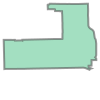

In [40]:
tessellation.iloc[6,2]

### This Takes 3 hours to run

In [48]:
start_time = pd.to_datetime('2020/03/01 00:00:00')
end_time = pd.to_datetime('2020/03/30 23:59:59')
depr = DensityEPR()
tdf = depr.generate(start_time, 
                    end_time, 
                    tessellation, 
                    relevance_column='Population', #Take population into account
                    n_agents=10000, 
                    show_progress=True)

/Users/wendyshi2001/anaconda3/envs/skmob/lib/python3.9/site-packages/geopandas/geoseries.py:574: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
  0%|                                                 | 0/10000 [00:00<?, ?it/s]/Users/wendyshi2001/anaconda3/envs/skmob/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
100%|█████████████████████████████████████| 10000/10000 [29:25<00:00,  5.67it/s]


In [49]:
tdf.to_csv("IL_4Week_10000_realpop.csv")

#

#

# Visualizations

In [50]:
#data = ditras_tdf
data = tdf
person1 = data[data["uid"] == 5].copy().reset_index()
person1 = person1.drop(columns = 'index')
print(person1.shape)
person1.head(5)

(474, 4)


,uid,datetime,lat,lng
0,5,2020-03-01 00:00:00.000000,41.896776,-87.753807
1,5,2020-03-01 00:56:03.010841,41.831380,-87.789194
2,5,2020-03-01 01:48:36.009937,41.896776,-87.753807
3,5,2020-03-01 02:22:07.963113,41.831380,-87.789194
4,5,2020-03-01 12:22:39.560320,41.835829,-87.789680


In [51]:
plotting_data = skmob.TrajDataFrame(person1, latitude='lat', datetime='datetime', user_id='uid')

plotting_data.plot_trajectory(
    zoom=12,
    weight=3,
    opacity=0.9,
    max_users = 1,
    max_points=None, #trajectories will be down-sampled to have at most `max_points` points.
    tiles='OpenStreetMap'  # Built-in tile set, no attribution needed
)

#

# Home location

In [55]:
# now create a TrajDataFrame from the pandas DataFrame
#tdf = skmob.TrajDataFrame(data, latitude='lat', datetime='datetime', user_id='uid')
print(tdf.shape)
tdf.head(5)

(4697462, 4)


,uid,datetime,lat,lng
0,1,2020-03-01 00:00:00.000000,41.797640,-89.701132
1,1,2020-03-01 08:36:57.339869,41.792552,-89.700469
2,1,2020-03-01 09:14:04.636129,41.797640,-89.701132
3,1,2020-03-01 10:33:32.341722,41.792552,-89.700469
4,1,2020-03-01 17:08:49.213984,41.790875,-89.708589


In [56]:
hl_df = home_location(tdf)
hl_df.head(5)

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1640.38it/s]


,uid,lat,lng
0,1,41.792552,-89.700469
1,2,38.882036,-90.098574
2,3,40.082724,-88.328817
3,4,42.006063,-88.163496
4,5,41.831380,-87.789194


In [57]:
hl_df.to_csv("Home_location_4Week_10000_IL_realpop.csv")